In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from tqdm import tqdm
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from captum.attr import IntegratedGradients, FeatureAblation
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage.io import imread
from skimage import filters
import matplotlib.pyplot as plt
from skimage.morphology import disk, binary_erosion, binary_dilation, binary_opening, binary_closing
import numpy as np
from scipy.ndimage import binary_fill_holes
import pyclesperanto_prototype as cle

C:\Users\madri\.conda\envs\mlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Fine tune pretrained model

Load an ImageNet-preinitialized ResNet50.

In [87]:
# Load ResNet50 pre-trained on ImageNet
model = torchvision.models.resnet50(pretrained=True)

Finetune the ResNet50 on Imagewoof, a subset of 10 dog breed classes from ImageNet


In [88]:
# If you want to do finetuning then set requires_grad = False
for param in model.parameters():
    param.requires_grad = False
    
# Fine-tune the model on Imagewoof
num_classes = 10
model.fc = torch.nn.Linear(model.fc.in_features,num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Perform preprocessing

Adequate preprocessing and augmentation pipeline

In [89]:
# Define the transformations for the dataset
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the Imagewoof dataset
train_dataset = ImageFolder('imagewoof2/train', transform=train_transforms)
val_dataset = ImageFolder('imagewoof2/val', transform=val_transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Hyperparameters
learning_rate = 1e-3
batch_size = 32
num_epochs = 5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the finetuned network

In [90]:
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [00:45<00:00,  6.21it/s]


Cost at epoch 0 is 0.41459


100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [00:44<00:00,  6.42it/s]


Cost at epoch 1 is 0.21560


100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [00:44<00:00,  6.32it/s]


Cost at epoch 2 is 0.21263


100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [00:45<00:00,  6.23it/s]


Cost at epoch 3 is 0.19314


100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [00:44<00:00,  6.33it/s]

Cost at epoch 4 is 0.18185


# Validate the model

In [91]:
def check_accuracy(loader, model):

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

check_accuracy(train_loader, model)

Got 8704 / 9025 with accuracy 96.44


In [92]:
# Extract 10 "Golden Retriever" and 10 "Shih-Tzu" samples from Imagewoof
golden_retriever_samples = []
shih_tzu_samples = []

sample = ImageFolder('imagewoof2/train')

for inputs, labels in sample:
    if labels == 6 and len(golden_retriever_samples) < 10:
        golden_retriever_samples.append(inputs)
    elif labels == 0 and len(shih_tzu_samples) < 10:
        shih_tzu_samples.append(inputs)
    
    if len(golden_retriever_samples) == 10 and len(shih_tzu_samples) == 10:
        break

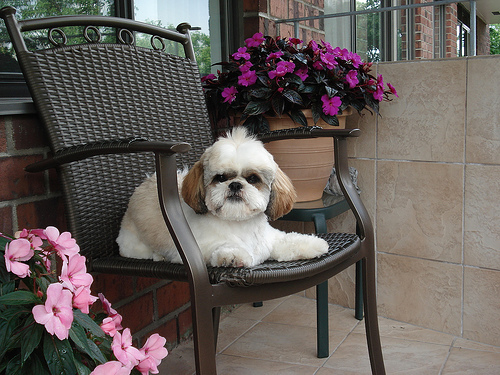

In [93]:
# Pick random ShihTzu image
import random
num1 = random.randint(0, 9)
shih_tzu = shih_tzu_samples[num1]
shih_tzu 

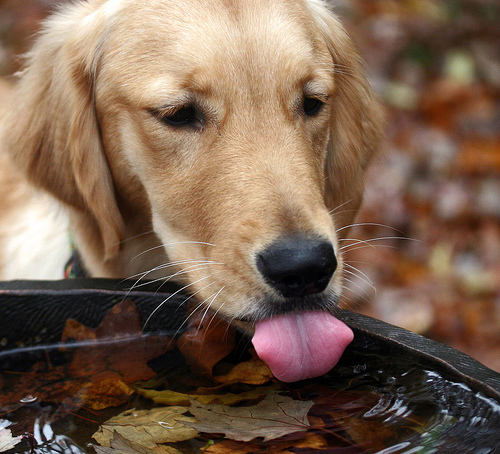

In [94]:
img = golden_retriever_samples[2]
img

In [95]:
model = model.eval()

Transform the extracted Golden Retriever image to apply feature ablation

In [96]:
#Transform the image
transform = transforms.Compose([
    transforms.ToTensor()])

input = transform(img)
input = input.unsqueeze(0)
input = input.to(device=device)

# Integrated Gradients : gradient-based

In [97]:
# Applying Integrated Gradients on the image
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=6, internal_batch_size=1, n_steps=200, baselines=input * 0)

<h3> Visualisation</h3>

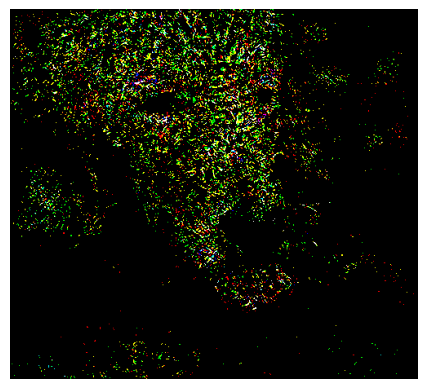

In [98]:
#Convert the extracted attributions to img
attr_img = ToPILImage()(attributions_ig[0])

# Visualize the binary mask
plt.axis('off')
plt.imshow(attr_img,cmap='gray')

# Command used for hiding whitespaces and border.
plt.savefig('image_ig.png', bbox_inches='tight', pad_inches=0)

# Show the plots
plt.show()

<h3>Binarization threshold: Otsu's thresholding</h3>

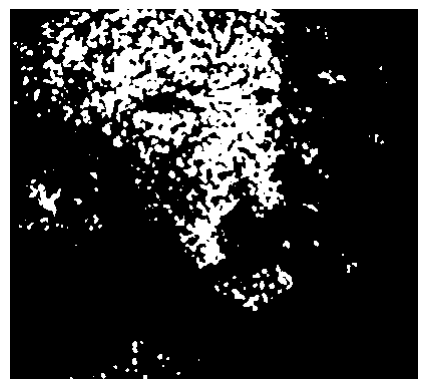

In [99]:
# Convert the attribution map to grayscale
gray_ig = cv2.imread('image_ig.png', cv2.IMREAD_GRAYSCALE)
blurred_ig = cv2.GaussianBlur(gray_ig, (7, 7), 0)

# Apply Otsu's thresholding to create a binary mask
(T_ig, threshOtsu_ig) = cv2.threshold(blurred_ig, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')

# Visualize the binary mask
plt.imshow(threshOtsu_ig,cmap='gray')

# Show the plots
plt.show()


<h3> Translate into binary masks </h3>

A typical post-processing step after thresholding is refining binary masks. This step can be crucial to smooth outlines around segmented objects, remove single pixels which were segmented as positive and for filling black holes in white regions.

Text(0.5, 1.0, 'closed')

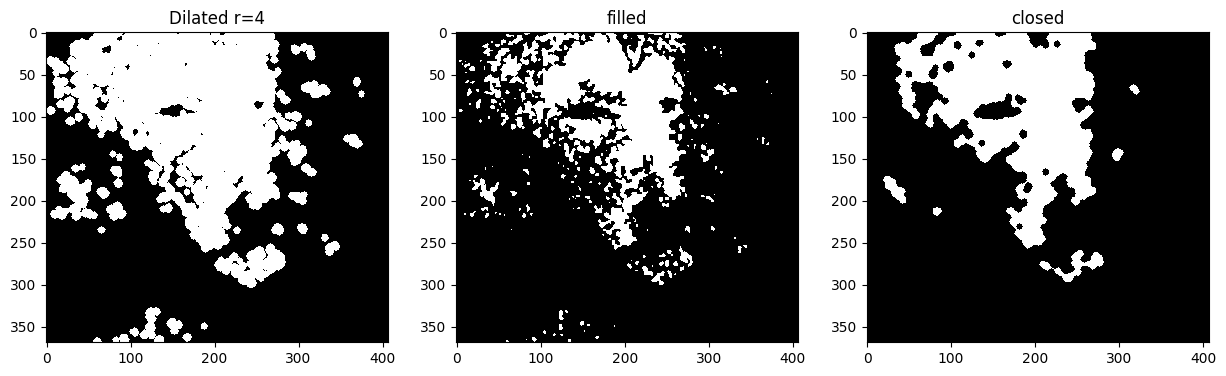

In [100]:
#dilated : dilation turns black pixels white which have a white neighbor.
dilated4_ig = binary_dilation(threshOtsu_ig, disk(4))

#fill_holes 
filled_ig = binary_fill_holes(threshOtsu_ig)

#closed = By combining operations such as erosion and dilation subsequently, one can close and open binary images
closed2_ig = binary_closing(threshOtsu_ig, disk(4))
opened_ig = binary_opening(closed2_ig, disk(4))
closed_ig = binary_closing(opened_ig, disk(4))

#Visualise the different approaches
fig, axs = plt.subplots(1, 3, figsize=(15,15))

cle.imshow(dilated4_ig, plot=axs[0])
axs[0].set_title('Dilated r=4')

cle.imshow(filled_ig, plot=axs[1])
axs[1].set_title('filled')

cle.imshow(closed_ig, plot=axs[2])
axs[2].set_title('closed')

Out of all the approaches 'dilated' produces better binary mask segemnetaion

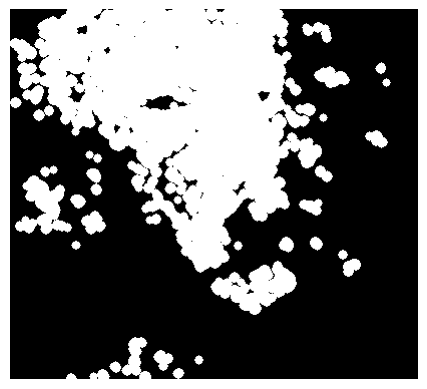

In [101]:
# Visualize the binary mask
plt.axis('off')
plt.imshow(dilated4_ig,cmap='gray')
# Command used for hiding whitespaces and border.
plt.savefig('mask_ig.png', bbox_inches='tight', pad_inches=0)
# Show the plots
plt.show()

<h3> Hugging Faces PaintByExample API </h3>

In [102]:
from diffusers import DiffusionPipeline
from PIL import Image
img_url = img
mask_url = Image.open('mask_ig.png')
example_url = shih_tzu

pipe = DiffusionPipeline.from_pretrained(
    "Fantasy-Studio/Paint-by-Example",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

init_image = img_url.resize((512, 512))
mask_image = mask_url.resize((512, 512))
example_image = example_url.resize((512, 512))

result_ig = pipe(image=init_image, mask_image=mask_image, example_image=example_image).images[0]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


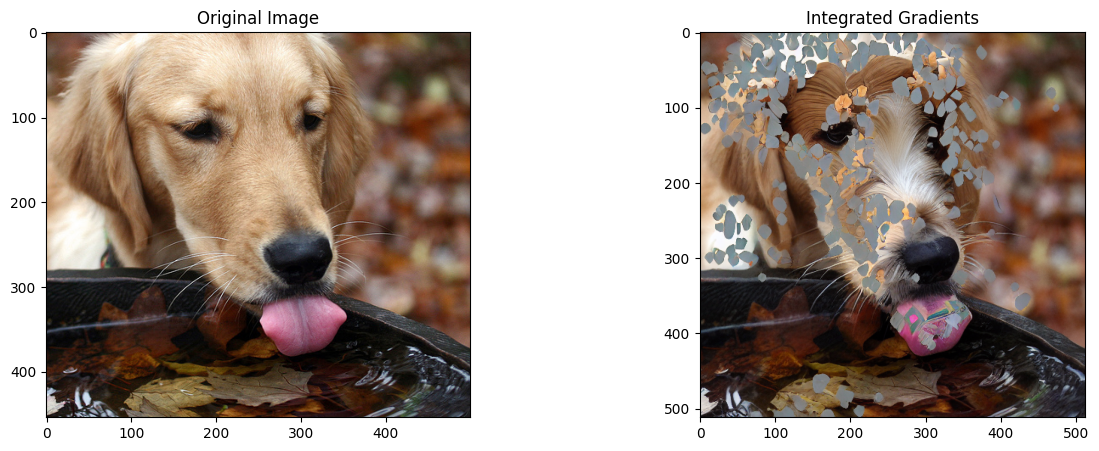

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[1].imshow(result_ig)
axs[1].set_title("Integrated Gradients")
plt.show()

# Feature Ablation

extract regions of an image, that show a high influence on the class prediction

In [13]:
# Applying Feature Ablation on the image
fa = FeatureAblation(model)
attributions_fa = fa.attribute(input, target=6, baselines=input * 0,perturbations_per_eval=1, show_progress=True)

Feature Ablation attribution: 100%|██████████████████████████████████████████| 681001/681001 [3:21:03<00:00, 56.45it/s]


<h3> Visualisation</h3>

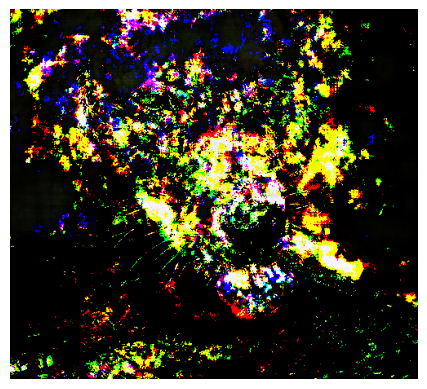

In [104]:
#Convert the extracted attributions to img
attr_fa = ToPILImage()(attributions_fa[0])

# Visualize the binary mask
plt.axis('off')
plt.imshow(attr_fa,cmap='gray')

# Command used for hiding whitespaces and border.
plt.savefig('image_fa.png', bbox_inches='tight', pad_inches=0)

# Show the plots
plt.show()

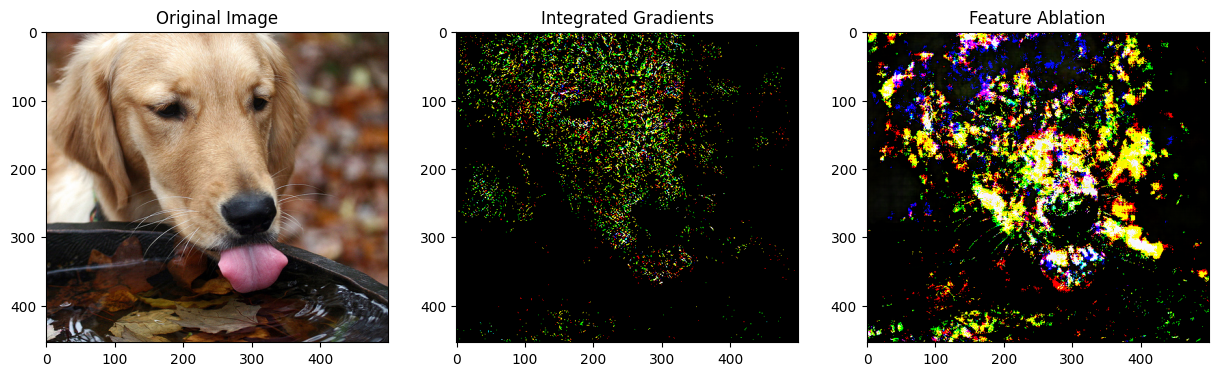

In [105]:
#Compare the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title("Original Image")

axs[1].imshow(attr_img, cmap='jet')
axs[1].set_title("Integrated Gradients")

axs[2].imshow(attr_fa, cmap='jet')
axs[2].set_title("Feature Ablation")

plt.show()

<h3>Binarization threshold: Otsu's thresholding</h3>

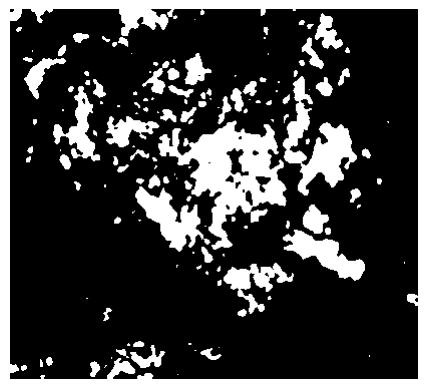

In [106]:
# Convert the attribution map to grayscale
gray_fa = cv2.imread('image_fa.png', cv2.IMREAD_GRAYSCALE)
blurred_fa = cv2.GaussianBlur(gray_fa, (7, 7), 0)

# Apply Otsu's thresholding to create a binary mask
(T_fa, threshOtsu_fa) = cv2.threshold(blurred_fa, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')

# Visualize the binary mask
plt.imshow(threshOtsu_fa,cmap='gray')

# Show the plots
plt.show()

<h3> Translate into binary masks </h3>

A typical post-processing step after thresholding is refining binary masks. This step can be crucial to smooth outlines around segmented objects, remove single pixels which were segmented as positive and for filling black holes in white regions.

Text(0.5, 1.0, 'closed')

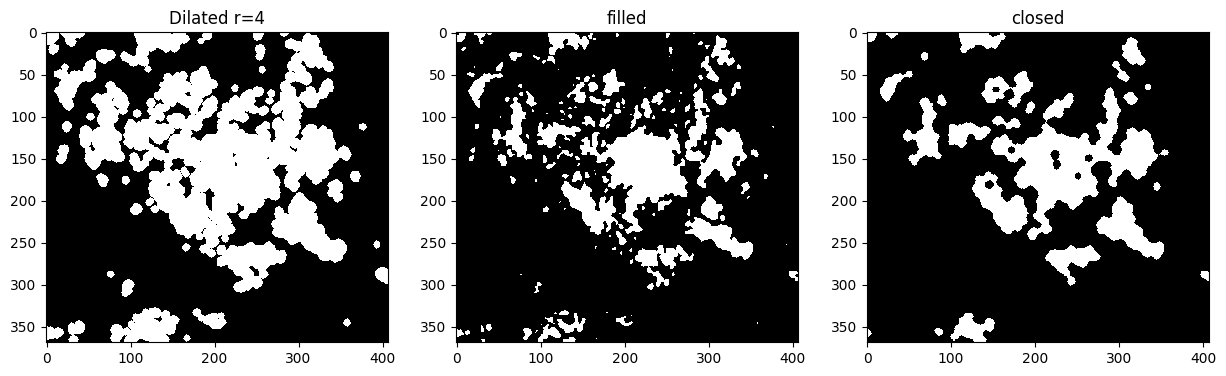

In [107]:
#dilated : dilation turns black pixels white which have a white neighbor.
dilated4_fa = binary_dilation(threshOtsu_fa, disk(4))

#fill_holes 
filled_fa = binary_fill_holes(threshOtsu_fa)

#closed = By combining operations such as erosion and dilation subsequently, one can close and open binary images
closed2_fa = binary_closing(threshOtsu_fa, disk(4))
opened_fa = binary_opening(closed2_fa, disk(4))
closed_fa = binary_closing(opened_fa, disk(4))

#Visualise the different approaches
fig, axs = plt.subplots(1, 3, figsize=(15,15))

cle.imshow(dilated4_fa, plot=axs[0])
axs[0].set_title('Dilated r=4')

cle.imshow(filled_fa, plot=axs[1])
axs[1].set_title('filled')

cle.imshow(closed_fa, plot=axs[2])
axs[2].set_title('closed')

Out of all the approaches 'dilated' produces better binary mask segemnetaion

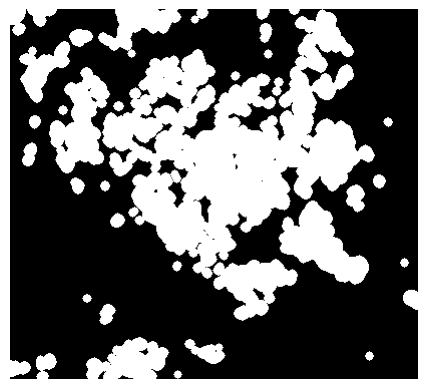

In [108]:
# Visualize the binary mask
plt.axis('off')
plt.imshow(dilated4_fa,cmap='gray')
# Command used for hiding whitespaces and border.
plt.savefig('mask_fa.png', bbox_inches='tight', pad_inches=0)
# Show the plots
plt.show()

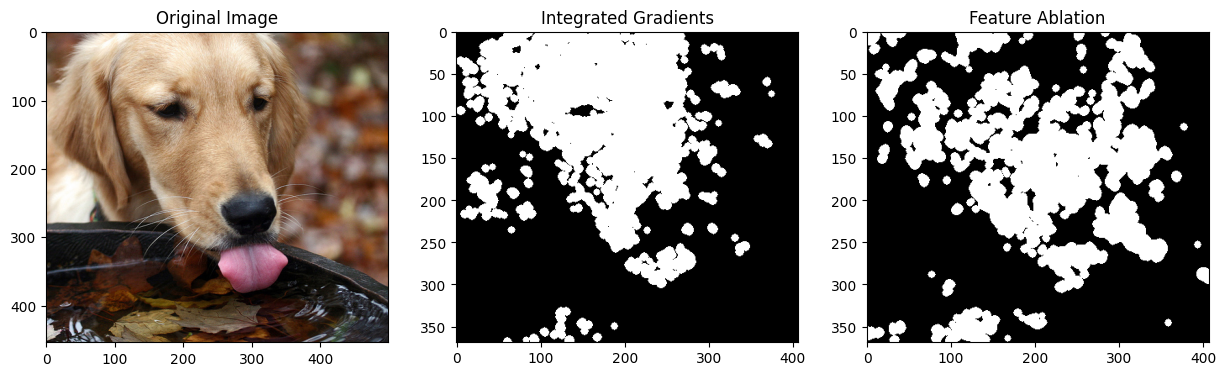

In [109]:
#Compare the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title("Original Image")

axs[1].imshow(dilated4_ig, cmap='gray')
axs[1].set_title("Integrated Gradients")

axs[2].imshow(dilated4_fa, cmap='gray')
axs[2].set_title("Feature Ablation")

plt.show()

<h3> Hugging Faces PaintByExample API </h3>

In [110]:
from diffusers import DiffusionPipeline
from PIL import Image
img_url = img
mask_url = Image.open('mask_fa.png')
example_url = shih_tzu

pipe = DiffusionPipeline.from_pretrained(
    "Fantasy-Studio/Paint-by-Example",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

init_image = img_url.resize((512, 512))
mask_image = mask_url.resize((512, 512))
example_image = example_url.resize((512, 512))

result_fa = pipe(image=init_image, mask_image=mask_image, example_image=example_image).images[0]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.77it/s]


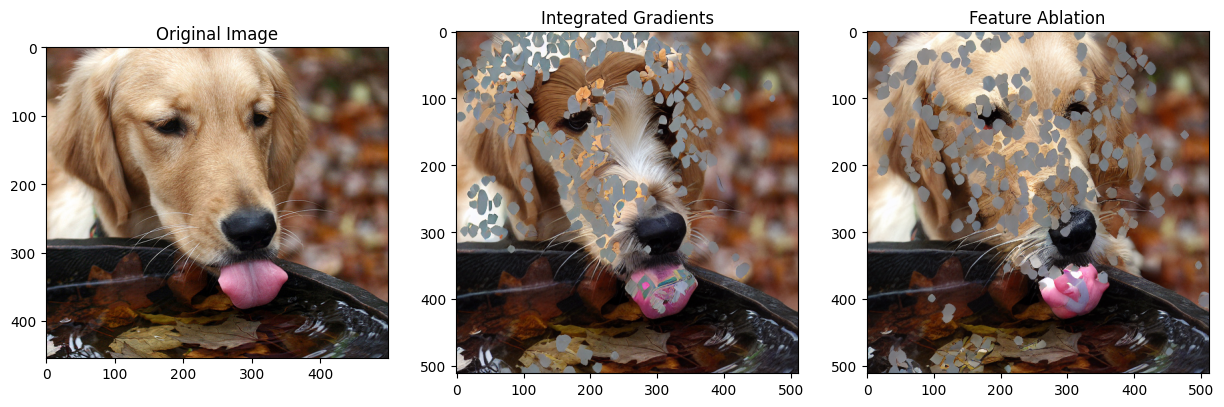

In [111]:
#Compare the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title("Original Image")

axs[1].imshow(result_ig)
axs[1].set_title("Integrated Gradients")

axs[2].imshow(result_fa)
axs[2].set_title("Feature Ablation")

plt.show()

I worked with only one image as to extract features via Feature Ablation it took approx 3 hrs